In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import collections
from sklearn import model_selection
import math
import os

import sys
sys.path.append('../')

from losses import triplet_hard_loss, triplet_semihard_loss
from model import create_model
from generator import create_singlet_dataset, create_triplet_dataset, preprocess_input, read_data
from optimizer import get_optimizer
from config import config

tf.config.set_visible_devices([], 'GPU')

input_path = '../../input/landmark-retrieval-2020/'

In [2]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    return tf.image.decode_jpeg(image, channels=3)
    

data = read_data(input_path)

(533, 800, 3)


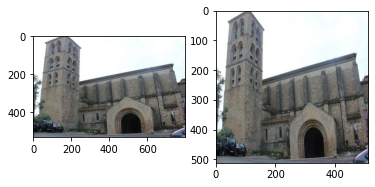

In [3]:
im1= read_image(data.iloc[734].path)
print(im1.shape)
im2 = tf.image.resize(
            im1, (512, 512), method='bilinear')
im2 = tf.cast(im2, dtype='uint8')

fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1)
axes[1].imshow(im2)

In [4]:
dataset = create_singlet_dataset(
    input_path='../'+config['input_path'], 
    batch_size=16, 
    input_size=config['input_size'], 
    pad_on_resize=config['pad_on_resize'], 
    K=config['K'],
    shuffle_buffer_size=10000)

for x, y in dataset.take(1):
    pass

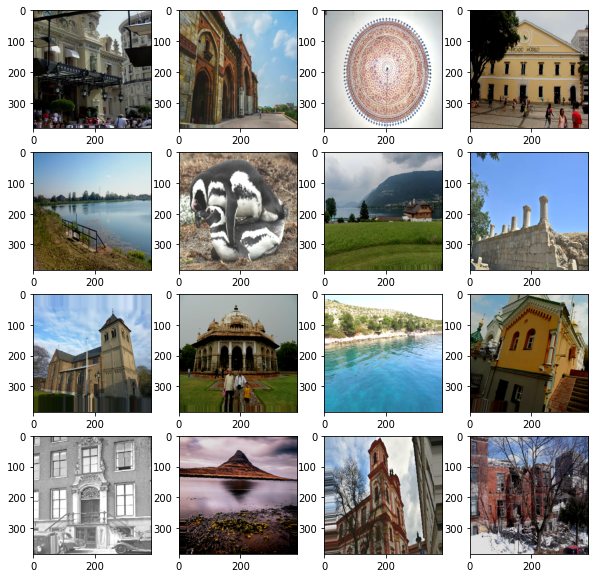

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(x[i].numpy())

In [ ]:
def _get_transform_matrix(rotation, shear, hzoom, wzoom, hshift, wshift):

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])

    # convert degrees to radians
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')

    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    rot_mat = get_3x3_mat([c1,    s1,   zero ,
                           -s1,   c1,   zero ,
                           zero,  zero, one ])

    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_mat = get_3x3_mat([one,  s2,   zero ,
                             zero, c2,   zero ,
                             zero, zero, one ])

    zoom_mat = get_3x3_mat([one/hzoom, zero,      zero,
                            zero,      one/wzoom, zero,
                            zero,      zero,      one])

    shift_mat = get_3x3_mat([one,  zero, hshift,
                             zero, one,  wshift,
                             zero, zero, one   ])

    return tf.matmul(
        tf.matmul(rot_mat, shear_mat),
        tf.matmul(zoom_mat, shift_mat)
    )

def _spatial_transform(image,
                       rotation=5.0,
                       shear=2.0,
                       hzoom=8.0,
                       wzoom=8.0,
                       hshift=8.0,
                       wshift=8.0,
                       p=0.5):
    

    dim = tf.gather(tf.shape(image), 0)
    xdim = dim % 2
    
    # random rotation, shear, zoom and shift
    r1, r2, r3, r4 = tf.random.uniform(shape=(4,), minval=1, maxval=1)
    if r1 > p:
        rotation = rotation * tf.random.normal([1], dtype='float32')
    else:
        rotation = tf.constant([0.0])
        
    if r2 > p:
        shear = shear * tf.random.normal([1], dtype='float32')
    else:
        shear = tf.constant([0.0])
        
    if r3 > p:
        hzoom = 1.0 + tf.random.normal([1], dtype='float32') / hzoom
        wzoom = 1.0 + tf.random.normal([1], dtype='float32') / wzoom
    else:
        hzoom, wzoom = tf.constant([1.0]), tf.constant([1.0])
    
    if r4 > p:
        hshift = hshift * tf.random.normal([1], dtype='float32')
        wshift = wshift * tf.random.normal([1], dtype='float32')
    else:
        hshift, wshift = tf.constant([0.0]), tf.constant([0.0])

    m = _get_transform_matrix(
        rotation, shear, hzoom, wzoom, hshift, wshift)

    # list destination pixel indices
    x = tf.repeat(tf.range(dim//2, -dim//2,-1), dim)
    y = tf.tile(tf.range(-dim//2, dim//2), [dim])
    z = tf.ones([dim*dim], dtype='int32')
    idx = tf.stack([x,y,z])

    # rotate destination pixels onto origin pixels
    idx2 = tf.matmul(m, tf.cast(idx, dtype='float32'))
    idx2 = tf.cast(idx2, dtype='int32')
    idx2 = tf.clip_by_value(idx2, -dim//2+xdim+1, dim//2)

    # find origin pixel values
    idx3 = tf.stack([dim//2-idx2[0,], dim//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))

    image = tf.reshape(d, [dim, dim, 3])
    
    return image

def _pixel_transform(image,
                     hue_delta=0.0,
                     saturation_delta=0.0,
                     contrast_delta=0.1,
                     brightness_delta=0.2):
    
    if hue_delta > 0:
        image = tf.image.random_hue(
            image, hue_delta)
    if saturation_delta > 0:
        image = tf.image.random_saturation(
            image, 1-saturation_delta, 1+saturation_delta)
    if contrast_delta > 0:
        image = tf.image.random_contrast(
            image, 1-contrast_delta, 1+contrast_delta)
    if brightness_delta > 0:
        image = tf.image.random_brightness(
            image, brightness_delta)
    
    shape = image.shape
    
    return image




In [ ]:
print(im1.shape)
im_aug = _spatial_transform(im2)
print(im_aug.shape)
im_aug = _pixel_transform(im_aug)
plt.imshow(im_aug)

In [ ]:
model1 = create_model(
    input_shape=config['input_size'],
    n_classes=config['n_classes'],
    dense_units=config['dense_units'],
    dropout_rate=config['dropout_rate'],
    regularization_factor=config['regularization_factor'],
    loss=config['loss']['type'],
    scale=config['loss']['scale'],
    margin=config['loss']['margin'],
)
model1.load_weights('../../output/weights/model.h5')
model1 = tf.keras.Model(
    inputs=model1.get_layer('input/image').input,
    outputs=model1.get_layer('head/dense').output
)

In [ ]:
im1 = read_image(data.iloc[4].path.split(',')[0])
im2 = read_image(data.iloc[4].path.split(',')[3])
im3 = read_image(data.iloc[4003].path.split(',')[1])


im1 = preprocess_input(
        im1, config['input_size'][:2], config['pad_on_resize'])
im2 = preprocess_input(
        im2, config['input_size'][:2], config['pad_on_resize'])
im3 = preprocess_input(
        im3, config['input_size'][:2], config['pad_on_resize'])

emb1 = tf.math.l2_normalize(model1(im1[tf.newaxis]), axis=1)[0]
emb2 = tf.math.l2_normalize(model1(im2[tf.newaxis]), axis=1)[0]
emb3 = tf.math.l2_normalize(model1(im3[tf.newaxis]), axis=1)[0]


fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for lab, im, ax in zip(['anchor', 'positive', 'negative'], [im1, im2, im3], axes.reshape(-1)):
    ax.imshow(im);
    ax.set_title(lab)
    ax.axis('off')
    
print('distance between anchor and positive =', np.linalg.norm(emb1-emb2))
print('distance between anchor and negative =', np.linalg.norm(emb1-emb3))


# distance between anchor and positive = 0.94654644
# distance between anchor and negative = 1.3443389

# distance between anchor and positive = 0.96240777
# distance between anchor and negative = 1.3401006

In [ ]:
served_model = tf.saved_model.load('../../tmp/model/')
model2 = served_model.signatures["serving_default"]

In [ ]:
im1 = read_image(data.iloc[4].path.split(',')[0])
im2 = read_image(data.iloc[4].path.split(',')[3])
im3 = read_image(data.iloc[4003].path.split(',')[1])

emb1 = model2(input_image=im1)['global_descriptor']
emb2 = model2(input_image=im2)['global_descriptor']
emb3 = model2(input_image=im3)['global_descriptor']

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for lab, im, ax in zip(['anchor', 'positive', 'negative'], [im1, im2, im3], axes.reshape(-1)):
    ax.imshow(im);
    ax.set_title(lab)
    ax.axis('off')
    
print('distance between anchor and positive =', np.linalg.norm(emb1-emb2))
print('distance between anchor and negative =', np.linalg.norm(emb1-emb3))

In [ ]:
emb1

In [ ]:
print(emb1)

In [ ]:
print(emb2)

In [ ]:
emb = np.random.uniform(0, 1, size=(256, 256, 3))

In [ ]:
out = model(emb[np.newaxis])

In [ ]:
tf.math.l2_normalize(out, axis=1)

In [ ]:
tf.math.l2_normalize(out[0])